# Solving nonlinear diffusion-reaction system with GAN-based FP and variational inference using different parameterizations 

We consider a one-dimensional nonlinear diffusion-reaction equation:

$$D\partial_x^2 u - k_r u^3 = f, x\in[-1, 1], D=0.01, k_r=0.2$$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

#### Common functions

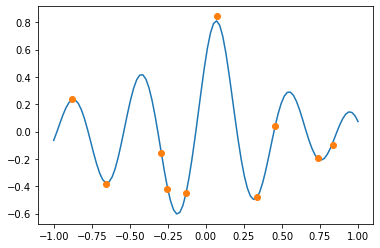

In [2]:
def plot1d(x, y, x_test, y_test, y_samples, xlim=None, ylim=None, title="", ylabel=""):
    y_mean = np.mean(y_samples, axis=0)
    y_std = np.std(y_samples, axis=0)

    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x, y, "k.", markersize=10, label="Training data")
    plt.plot(x_test, y_test, "k-", label="Exact")
    plt.plot(x_test, y_mean, "r--", label="Mean")
    plt.fill_between(
        x_test.ravel(),
        y_mean + 2 * y_std,
        y_mean - 2 * y_std,
        alpha=0.3,
        facecolor="c",
        label="2 stds",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.show()
    

def load_data(noise):
    data = sio.loadmat("../../dataset/FP_1D.mat")
    x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
    idx = np.random.choice(100, 10, replace=False)
    x_f_train, f_train = x_test[idx, ...], f_test[idx, ...]
    f_train = f_train + noise*np.random.normal(size=f_train.shape)
    return x_f_train, f_train, x_test, u_test, f_test


def pde_fn(x, u):
    D = 0.01
    k = 0.2
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    return D * u_xx - k * u**3


np.random.seed(666)
noise = 0.01
x_f_train, f_train, x_test, u_test, f_test = load_data(noise)

plt.plot(x_test, f_test)
plt.plot(x_f_train, f_train, 'o')

#### Load pre-trained GAN-based FP

In [3]:
branch = neuq.utils.load_network(
    file_name="../../dataset/pretrained_model/FP_1D/branch.npy", activation=tf.tanh, resnet=True
)
_trunk = neuq.utils.load_network(
    file_name="../../dataset/pretrained_model/FP_1D/trunk.npy", activation=tf.tanh, resnet=False
)

# enforce boundary conditions
def trunk(inputs):
    return (inputs - 1) * (inputs + 1) * _trunk(inputs)

#### Bayesian inference with HMC, as a reference

In [4]:
generator = neuq.surrogates.Generator(
    branch=branch, trunk=trunk, variable_shape=[40]
)
prior = neuq.variables.const.Samplable(mean=0, sigma=1, shape=[40])
process = neuq.process.Process(
    surrogate=generator,
    prior=prior,
)

likelihood = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process],
    pde=pde_fn,
    sigma=0.01,
)

model = neuq.models.Model(
    processes=[process],
    likelihoods=[likelihood],
)

method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.1,
    leapfrog_step=50,
)
model.compile(method)

samples, results = model.run()
print("Acceptance rate: ", np.mean(results))

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate:  0.521


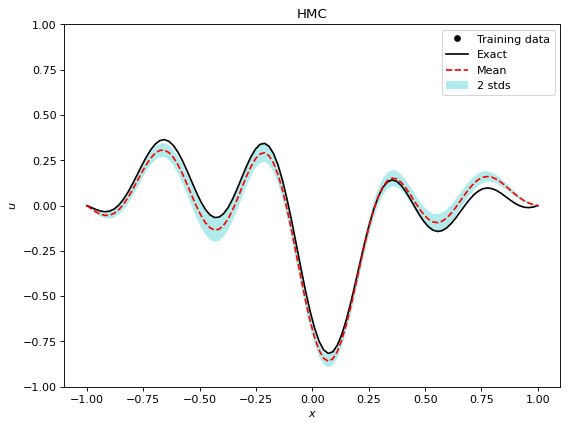

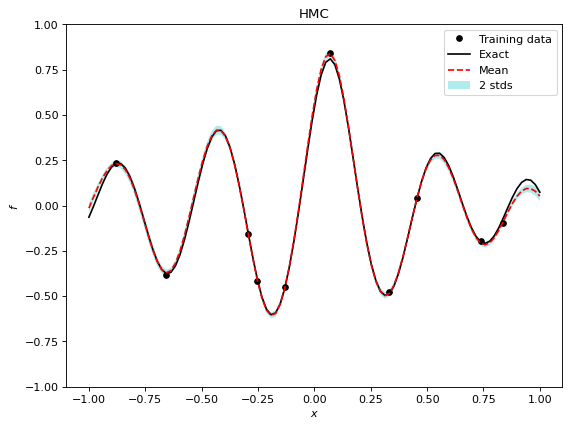

In [5]:
u_pred, = model.predict(x_test, samples, [process])
f_pred, = model.predict(x_test, samples, [process], pde_fn=pde_fn)
plot1d([], [], x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-1, 1], title="HMC")
plot1d(x_f_train, f_train, x_test, f_test, f_pred[..., 0], ylabel="$f$", ylim=[-1, 1], title="HMC")

#### Variational inference (VI) with different parameterized distributions

1. Independent normal distribution, parameterized by its mean and standard deviation
2. Independent Binomial distribution with fixed $p$, parametrized by its value.

#### Independent Normal distribution 

In [6]:
prior = neuq.variables.const.Variational(mean=0, sigma=1.0, shape=[40], trainable=False)
posterior = neuq.variables.const.Variational(mean=0, sigma=0.01, shape=[40], trainable=True)
process = neuq.process.Process(
    surrogate=generator,
    prior=prior,
    posterior=posterior,
)

likelihood = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process],
    pde=pde_fn,
    sigma=0.01,
)

model = neuq.models.Model(
    processes=[process],
    likelihoods=[likelihood],
)
method = neuq.inferences.VI(
    batch_size=128, num_samples=1000, num_iterations=20000,
)
model.compile(method)

Supporting backend tensorflow.compat.v1

Compiling a VI method

Iteration:  0 , loss:  1155.0166
Iteration:  100 , loss:  681.54315
Iteration:  200 , loss:  476.73102
Iteration:  300 , loss:  351.0908
Iteration:  400 , loss:  274.12094
Iteration:  500 , loss:  230.65817
Iteration:  600 , loss:  203.1576
Iteration:  700 , loss:  183.69632
Iteration:  800 , loss:  169.59894
Iteration:  900 , loss:  158.72021
Iteration:  1000 , loss:  148.49214
Iteration:  1100 , loss:  141.84941
Iteration:  1200 , loss:  134.19183
Iteration:  1300 , loss:  127.94132
Iteration:  1400 , loss:  122.06197
Iteration:  1500 , loss:  116.233
Iteration:  1600 , loss:  111.15518
Iteration:  1700 , loss:  106.23013
Iteration:  1800 , loss:  100.39615
Iteration:  1900 , loss:  97.21996
Iteration:  2000 , loss:  92.29892
Iteration:  2100 , loss:  88.73419
Iteration:  2200 , loss:  84.8828
Iteration:  2300 , loss:  80.277435
Iteration:  2400 , loss:  77.003525
Iteration:  2500 , loss:  74.57646
Iteration:  2600 , los

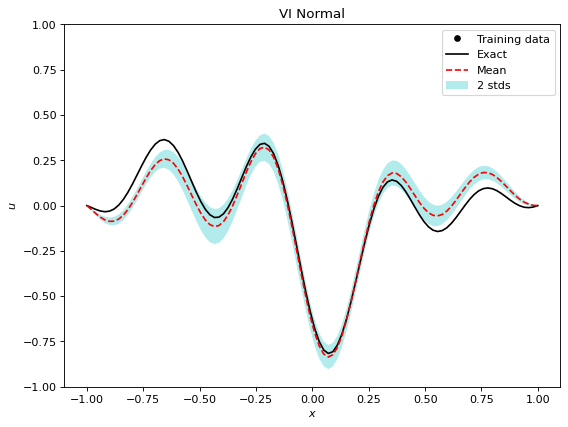

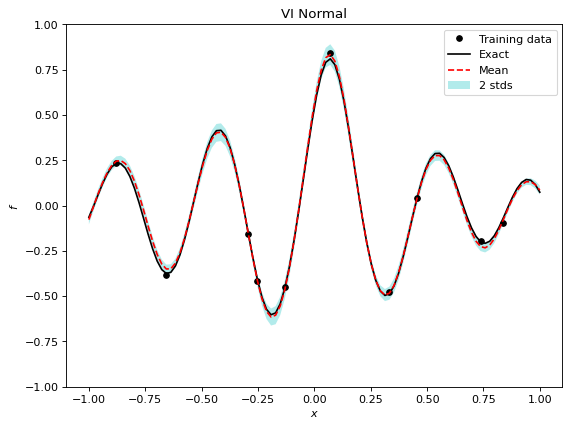

In [7]:
samples = model.run()
u_pred, = model.predict(x_test, samples, [process])
f_pred, = model.predict(x_test, samples, [process], pde_fn=pde_fn)
plot1d([], [], x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-1, 1], title="VI Normal")
plot1d(x_f_train, f_train, x_test, f_test, f_pred[..., 0], ylabel="$f$", ylim=[-1, 1], title="VI Normal")

#### Independent Bernoulli distribution with fixed $p$

In [8]:
class Bernoulli(neuq.variables._Variational):
    
    def __init__(self, value, p=0.2, shape=[], initializer=None):
        super().__init__()
        if initializer is None:
            init = tf.keras.initializers.constant(value=value)
        else:
            init = initializer
        self.v = tf.Variable(init(shape=shape), tf.float32)
        self.p = p
        
        self._trainable_variables = [self.v]
        self._trainable = True
    
    def log_prob(self, samples):
        # Note that this part in fact does not depend on the value of 
        # samples. It only depends on p, which is a fixed constant. Hence,
        # we can also set it to any constant and the results would be the
        # same.
        num_success = tf.reduce_sum(tf.cast(samples[0]>0, tf.float32), axis=-1)
        num_fail = self.v.shape[0] - num_success
        return num_success * tf.math.log(1-self.p) + num_fail * tf.math.log(self.p)
    
    def sample(self, sample_shape):
        v = tf.tile(self.v[None, ...], [sample_shape, 1])
        return [v * tf.cast(tf.random.uniform(v.shape) > self.p, tf.float32)]

In [9]:
prior = neuq.variables.const.Variational(mean=0, sigma=1.0, shape=[40], trainable=False)
posterior = Bernoulli(value=0.0, p=0.5, shape=[40], initializer=tf.keras.initializers.random_normal())
process = neuq.process.Process(
    surrogate=generator,
    prior=prior,
    posterior=posterior,
)

likelihood = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process],
    pde=pde_fn,
    sigma=0.01,
)

model = neuq.models.Model(
    processes=[process],
    likelihoods=[likelihood],
)
method = neuq.inferences.VI(
    batch_size=128, num_samples=1000, num_iterations=20000,
)
model.compile(method)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Supporting backend tensorflow.compat.v1

Compiling a VI method

Iteration:  0 , loss:  1014.08636
Iteration:  100 , loss:  731.37256
Iteration:  200 , loss:  556.587
Iteration:  300 , loss:  452.79
Iteration:  400 , loss:  368.67615
Iteration:  500 , loss:  349.57425
Iteration:  600 , loss:  296.6484
Iteration:  700 , loss:  271.45306
Iteration:  800 , loss:  235.03777
Iteration:  900 , loss:  231.03528
Iteration:  1000 , loss:  213.62724
Iteration:  1100 , loss:  190.22006
Iteration:  1200 , loss:  172.31163
Iteration:  1300 , loss:  173.59073
Iteration:  1400 , loss:  173.9904
Iteration:  1500 , loss:  159.10008
Iteration:  1600 , loss:  152.29236
Iteration:  1700 , loss:  144.03021
Iteration:  1800 , loss:  145.24525
Iteration:  1900 , loss:  143.0682
Iteration:  2000 , loss:  142.47115
Iteration:  2100 , loss:  142.84773
Iteration:  2200 , loss:  130.4667
Iteration

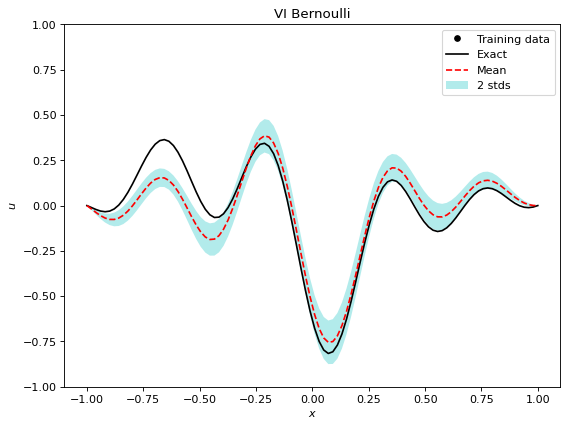

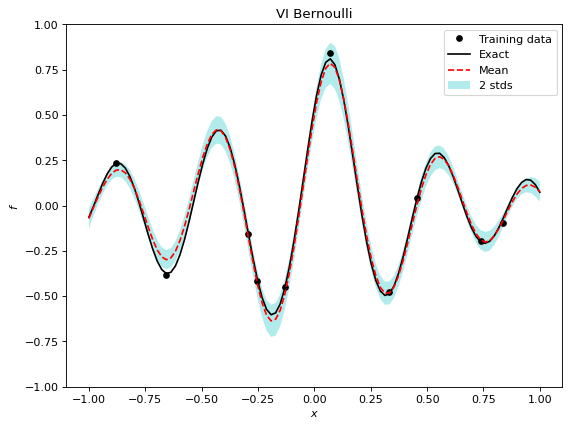

In [10]:
samples = model.run()
u_pred, = model.predict(x_test, samples, [process])
f_pred, = model.predict(x_test, samples, [process], pde_fn=pde_fn)
plot1d([], [], x_test, u_test, u_pred[..., 0], ylabel="$u$", ylim=[-1, 1], title="VI Bernoulli")
plot1d(x_f_train, f_train, x_test, f_test, f_pred[..., 0], ylabel="$f$", ylim=[-1, 1], title="VI Bernoulli")